# Quantile gradient boosting

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html

In [34]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

In [3]:
%load_ext watermark
%watermark -iv

seaborn   : 0.11.2
numpy     : 1.22.1
matplotlib: 3.5.1



In [4]:
pal = sns.color_palette()

## Generate data

In [5]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

In [6]:
rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

add noise

In [7]:
sigma = 0.5 + X.ravel() / 10
noise = rng.lognormal(sigma=sigma) - np.exp(sigma ** 2 / 2)
y = expected_y + noise

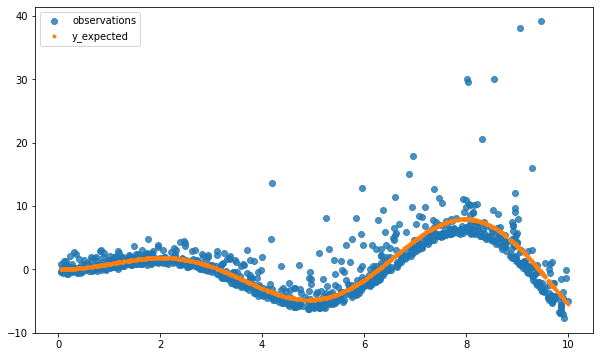

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X[:, 0], y, color=pal[0], alpha=0.8, label='observations')
ax.scatter(X[:, 0], expected_y, marker='.', color=pal[1], label='y_expected')
ax.legend()

split data into training and test sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Fit quantile regressors

In [43]:
quantiles = [0.05, 0.5, 0.95]

Fit gradient boosting regressors

In [44]:
all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)
for alpha in quantiles:
    gbr = GradientBoostingRegressor(
        loss="quantile", alpha=alpha, **common_params
    )
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

Fit mean square error gradient boosting regressor

In [45]:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

## Predict

In [46]:
x_val = np.atleast_2d(np.linspace(0, 10, 1000)).T

In [47]:
y_mse = all_models['mse'].predict(x_val)
y_lower = all_models['q 0.05'].predict(x_val)
y_upper = all_models['q 0.95'].predict(x_val)
y_med = all_models['q 0.50'].predict(x_val)

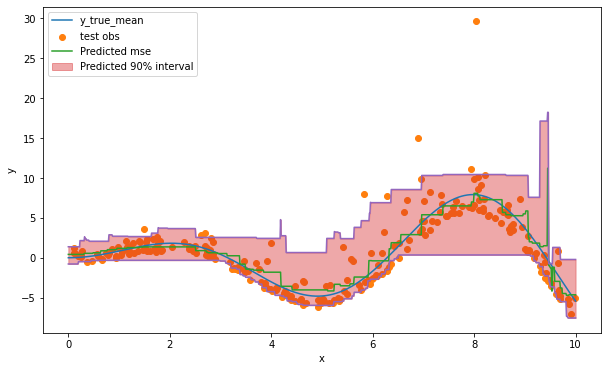

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_val, f(x_val), label='y_true_mean', color=pal[0])
ax.scatter(X_test, y_test, label='test obs', color=pal[1])
ax.plot(x_val, y_mse, label="Predicted mse", color=pal[2])
plt.plot(x_val, y_upper, color=pal[4])
plt.plot(x_val, y_lower, color=pal[4])
plt.fill_between(
    x_val.ravel(),
    y_lower,
    y_upper,
    color=pal[3],
    alpha=0.4,
    label="Predicted 90% interval",
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='upper left')

## Error metrics

In [58]:
results = []
for name, gbr in sorted(all_models.items()):
    metrics = {"model": name}
    y_pred = gbr.predict(X_train)
    for alpha in quantiles:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(
            y_train, y_pred, alpha=alpha
        )
    metrics["mse"] = mean_squared_error(y_train, y_pred)
    results.append(metrics)

In [59]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

In [60]:
pd.DataFrame(results).set_index('model').style.apply(highlight_min)

,pbl=0.05,pbl=0.50,pbl=0.95,mse
model,,,,
mse,0.715413,0.715413,0.715413,7.750348
q 0.05,0.127128,1.253445,2.379763,18.933253
q 0.50,0.305438,0.622811,0.940184,9.827917
q 0.95,3.909909,2.145957,0.382005,28.667219


In [61]:
results = []
for name, gbr in sorted(all_models.items()):
    metrics = {"model": name}
    y_pred = gbr.predict(X_test)
    for alpha in quantiles:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(
            y_test, y_pred, alpha=alpha
        )
    metrics["mse"] = mean_squared_error(y_test, y_pred)
    results.append(metrics)

pd.DataFrame(results).set_index("model").style.apply(highlight_min)

,pbl=0.05,pbl=0.50,pbl=0.95,mse
model,,,,
mse,0.917281,0.767498,0.617715,6.692901
q 0.05,0.144204,1.245961,2.347717,15.648026
q 0.50,0.412021,0.607752,0.803483,5.874771
q 0.95,4.354394,2.355445,0.356497,34.852774


## Calibrate the confidence interval